In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image


import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns
import time
from utils.model_utils import *
from utils.plot_utils import *
from utils.trainer import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64,64))])
dataset = ImageFolder("./data/",transform)

train_dataset,test_dataset = random_split(dataset,[round(0.7 * len(dataset)), round(0.3 * len(dataset))])

In [3]:
BATCH_SIZE = 16
SHUFFLE = True
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


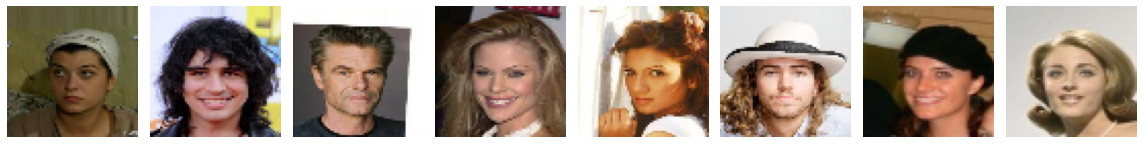

In [4]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


imgs, _ = next(iter(train_loader))
show_grid(imgs)


In [5]:
class ResNetVAE(nn.Module):

    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(3,32,32), sizes=[1024, 128, 10], act="ReLU"):
        """ Model initlaizer """
        
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation = get_act(act) 
        self.resnet = models.resnet18(pretrained=True)
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(self.resnet.fc.in_features, 256)
        self.fc_sigma = nn.Linear(self.resnet.fc.in_features, 256)
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = []
        resnet_layers = nn.Sequential(*(list(self.resnet.children())[:-1]))
        layers.append(resnet_layers)
        layers.append(nn.Flatten())
        

        
        encoder = nn.Sequential(*layers)

        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
       
        layers.append(nn.Linear(256,1024))
        layers.append(nn.BatchNorm1d(1024, momentum=0.01))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Unflatten(-1,(64,4,4)))
        convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )
        layers.append(convTrans6)
        layers.append(convTrans7)
        layers.append(convTrans8)


        decoder =nn.Sequential(*layers)




        return decoder
        
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        
        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = torch.nn.functional.interpolate(x_hat_flat,size=(64,64),mode='bilinear')
        
        return x_hat, (z, mu, log_var)


In [6]:
resvae = ResNetVAE()
resvae.to(device)

ResNetVAE(
  (activation): ReLU()
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [7]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target, reduction="sum")
    b_size = recons.shape[0]
#     recons_loss = F.binary_cross_entropy(recons.view(b_size,-1), target.view(b_size,-1), reduction='sum')
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)


In [8]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """

    loss_list = []
    recons_loss = []
    vae_loss = []

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass
        recons, (z, mu, log_var) = model(images)

        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        progress_bar.set_description(
            f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

    mean_loss = np.mean(loss_list)

    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath=""):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    vae_loss = []

    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)

        # Forward pass
        recons, (z, mu, log_var) = model(images)

        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())

        if(i == 0 and savefig):
            save_image(recons[:64].cpu(), os.path.join(
                savepath, f"recons{epoch}.png"))

    # Total correct predictions and loss
    loss = np.mean(loss_list)

    return loss


In [9]:
def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs, savepath, save_frequency=5):
    """ Training a model for a given number of epochs"""

    train_loss = []
    val_loss = []
    loss_iters = []

    for epoch in range(num_epochs):

        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss = eval_model(
            model=model, eval_loader=valid_loader, criterion=criterion,
            device=device, epoch=epoch, savefig=log_epoch, savepath=savepath
        )
        val_loss.append(loss)

        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer,
            criterion=criterion, epoch=epoch, device=device
        )

        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters

        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters,
                "name": "conv_vae"
            }
            save_model(model=model, optimizer=optimizer,
                       epoch=epoch, stats=stats, name="res_vae")

        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")

    print(f"Training completed")
    return train_loss, val_loss, loss_iters


In [10]:
savepath = "imgs/res_vae/"
optimizer = torch.optim.Adam(resvae.parameters(), lr=5e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=5, factor=0.1, verbose=True)

train_loss, val_loss, loss_iters = train_model(
    model=resvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
    train_loader=train_loader, valid_loader=test_loader, num_epochs=3500, savepath=savepath
)

/home/dhagash/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Epoch 1 Iter 8864: loss 322.86172. : 100%|██████████| 8864/8864 [02:37<00:00, 56.27it/s]


    Train loss: 376.38366
    Valid loss: 1576.02708


Epoch 6 Iter 8864: loss 324.96768. : 100%|██████████| 8864/8864 [02:40<00:00, 55.34it/s]


    Train loss: 275.51649
    Valid loss: 254.05189


Epoch 11 Iter 8864: loss 306.99341. : 100%|██████████| 8864/8864 [02:40<00:00, 55.15it/s]


    Train loss: 266.99951
    Valid loss: 250.29804


Epoch 16 Iter 8864: loss 241.84158. : 100%|██████████| 8864/8864 [02:40<00:00, 55.30it/s]


    Train loss: 262.6132
    Valid loss: 263.34976


Epoch 21 Iter 8864: loss 289.98038. : 100%|██████████| 8864/8864 [02:39<00:00, 55.59it/s]


    Train loss: 259.8354
    Valid loss: 247.37909


Epoch 24 Iter 8864: loss 294.62573. : 100%|██████████| 8864/8864 [02:38<00:00, 56.07it/s]


Epoch    24: reducing learning rate of group 0 to 5.0000e-04.


Epoch 26 Iter 8864: loss 239.86874. : 100%|██████████| 8864/8864 [02:38<00:00, 56.02it/s]


    Train loss: 253.14089
    Valid loss: 239.41741


Epoch 31 Iter 8864: loss 253.01913. : 100%|██████████| 8864/8864 [02:38<00:00, 55.91it/s]


    Train loss: 252.28398
    Valid loss: 239.32664


Epoch 36 Iter 8864: loss 240.80807. : 100%|██████████| 8864/8864 [02:40<00:00, 55.26it/s]


    Train loss: 251.9194
    Valid loss: 246.58996


Epoch 40 Iter 8864: loss 240.10039. : 100%|██████████| 8864/8864 [02:37<00:00, 56.22it/s]


Epoch    40: reducing learning rate of group 0 to 5.0000e-05.


Epoch 41 Iter 8864: loss 268.12427. : 100%|██████████| 8864/8864 [02:37<00:00, 56.46it/s]


    Train loss: 251.18977
    Valid loss: 238.68345


Epoch 46 Iter 8864: loss 263.96069. : 100%|██████████| 8864/8864 [02:37<00:00, 56.37it/s]


Epoch    46: reducing learning rate of group 0 to 5.0000e-06.
    Train loss: 250.96609
    Valid loss: 240.00619


Epoch 51 Iter 8864: loss 217.46303. : 100%|██████████| 8864/8864 [02:40<00:00, 55.18it/s]


    Train loss: 250.81612
    Valid loss: 237.06778


Epoch 56 Iter 8864: loss 235.93176. : 100%|██████████| 8864/8864 [02:36<00:00, 56.59it/s]


    Train loss: 250.81062
    Valid loss: 238.55711


Epoch 57 Iter 8864: loss 260.91534. : 100%|██████████| 8864/8864 [02:36<00:00, 56.53it/s]

Epoch    57: reducing learning rate of group 0 to 5.0000e-07.



Epoch 61 Iter 8864: loss 263.07544. : 100%|██████████| 8864/8864 [02:36<00:00, 56.74it/s]


    Train loss: 250.89818
    Valid loss: 237.61737


Epoch 65 Iter 8864: loss 284.13657. : 100%|██████████| 8864/8864 [02:35<00:00, 56.86it/s]

Epoch    65: reducing learning rate of group 0 to 5.0000e-08.



Epoch 66 Iter 8864: loss 264.46695. : 100%|██████████| 8864/8864 [02:40<00:00, 55.24it/s]


    Train loss: 250.79966
    Valid loss: 237.45516


Epoch 71 Iter 8864: loss 229.29778. : 100%|██████████| 8864/8864 [02:39<00:00, 55.55it/s]


Epoch    71: reducing learning rate of group 0 to 5.0000e-09.
    Train loss: 250.99949
    Valid loss: 237.73278


Epoch 76 Iter 8864: loss 248.61536. : 100%|██████████| 8864/8864 [02:38<00:00, 56.06it/s]


    Train loss: 250.8283
    Valid loss: 239.84623


Epoch 81 Iter 8864: loss 267.93759. : 100%|██████████| 8864/8864 [02:39<00:00, 55.47it/s]


    Train loss: 250.79838
    Valid loss: 238.72096


Epoch 86 Iter 8864: loss 265.82745. : 100%|██████████| 8864/8864 [02:36<00:00, 56.79it/s]


    Train loss: 250.8667
    Valid loss: 240.27976


Epoch 91 Iter 8864: loss 252.00053. : 100%|██████████| 8864/8864 [02:38<00:00, 56.05it/s]


    Train loss: 251.03725
    Valid loss: 237.86376


Epoch 96 Iter 8864: loss 259.73019. : 100%|██████████| 8864/8864 [02:37<00:00, 56.29it/s]


    Train loss: 250.88835
    Valid loss: 239.15534


Epoch 101 Iter 8864: loss 247.80385. : 100%|██████████| 8864/8864 [02:38<00:00, 55.90it/s]


    Train loss: 250.98363
    Valid loss: 237.59241


Epoch 106 Iter 8864: loss 292.65802. : 100%|██████████| 8864/8864 [02:37<00:00, 56.10it/s]


    Train loss: 250.96602
    Valid loss: 239.62154


Epoch 111 Iter 8864: loss 250.92216. : 100%|██████████| 8864/8864 [02:38<00:00, 55.79it/s]


    Train loss: 250.86472
    Valid loss: 247.30485


Epoch 116 Iter 8864: loss 254.19583. : 100%|██████████| 8864/8864 [02:36<00:00, 56.47it/s]


    Train loss: 250.83256
    Valid loss: 237.78096


Epoch 121 Iter 8864: loss 274.81714. : 100%|██████████| 8864/8864 [02:37<00:00, 56.30it/s]


    Train loss: 250.97387
    Valid loss: 237.50312


Epoch 126 Iter 8864: loss 248.40736. : 100%|██████████| 8864/8864 [02:38<00:00, 55.77it/s]


    Train loss: 250.74518
    Valid loss: 239.42645


Epoch 131 Iter 8864: loss 247.79584. : 100%|██████████| 8864/8864 [02:37<00:00, 56.35it/s]


    Train loss: 250.77175
    Valid loss: 240.8155


Epoch 136 Iter 8864: loss 313.65833. : 100%|██████████| 8864/8864 [02:38<00:00, 55.88it/s]


    Train loss: 250.88423
    Valid loss: 250.59684


Epoch 141 Iter 8864: loss 294.81525. : 100%|██████████| 8864/8864 [02:37<00:00, 56.21it/s]


    Train loss: 250.85517
    Valid loss: 238.11358


Epoch 146 Iter 8864: loss 285.15778. : 100%|██████████| 8864/8864 [02:37<00:00, 56.26it/s]


    Train loss: 250.89775
    Valid loss: 238.27808


Epoch 151 Iter 8864: loss 286.44360. : 100%|██████████| 8864/8864 [02:37<00:00, 56.38it/s]


    Train loss: 250.76977
    Valid loss: 240.6889


Epoch 156 Iter 8864: loss 233.44553. : 100%|██████████| 8864/8864 [02:37<00:00, 56.25it/s]


    Train loss: 250.78883
    Valid loss: 238.47586


Epoch 161 Iter 8864: loss 245.46419. : 100%|██████████| 8864/8864 [02:34<00:00, 57.24it/s]


    Train loss: 250.96345
    Valid loss: 243.80163


Epoch 166 Iter 8864: loss 271.36969. : 100%|██████████| 8864/8864 [02:34<00:00, 57.30it/s]


    Train loss: 250.83862
    Valid loss: 243.54445


Epoch 171 Iter 8864: loss 226.32722. : 100%|██████████| 8864/8864 [02:38<00:00, 55.93it/s]


    Train loss: 250.77124
    Valid loss: 238.21041


Epoch 176 Iter 8864: loss 223.96074. : 100%|██████████| 8864/8864 [02:31<00:00, 58.47it/s]


    Train loss: 250.96467
    Valid loss: 241.78483


Epoch 181 Iter 8864: loss 345.95029. : 100%|██████████| 8864/8864 [02:33<00:00, 57.79it/s]


    Train loss: 250.91014
    Valid loss: 238.47742


Epoch 186 Iter 8864: loss 273.07413. : 100%|██████████| 8864/8864 [02:34<00:00, 57.46it/s]


    Train loss: 250.88552
    Valid loss: 238.15861


Epoch 191 Iter 8864: loss 301.39627. : 100%|██████████| 8864/8864 [02:29<00:00, 59.17it/s]


    Train loss: 251.0389
    Valid loss: 239.70757


Epoch 196 Iter 8864: loss 290.31607. : 100%|██████████| 8864/8864 [02:32<00:00, 58.21it/s]


    Train loss: 250.81223
    Valid loss: 237.13735


Epoch 201 Iter 8864: loss 235.21707. : 100%|██████████| 8864/8864 [02:33<00:00, 57.91it/s]


    Train loss: 250.85946
    Valid loss: 240.38241


Epoch 206 Iter 8864: loss 249.26688. : 100%|██████████| 8864/8864 [02:33<00:00, 57.83it/s]


    Train loss: 250.84632
    Valid loss: 239.39014


Epoch 211 Iter 8864: loss 374.89511. : 100%|██████████| 8864/8864 [02:30<00:00, 58.79it/s]


    Train loss: 250.99749
    Valid loss: 240.82754


Epoch 216 Iter 8864: loss 239.41756. : 100%|██████████| 8864/8864 [02:30<00:00, 58.75it/s]


    Train loss: 250.85352
    Valid loss: 241.60728


Epoch 221 Iter 8864: loss 267.94058. : 100%|██████████| 8864/8864 [02:32<00:00, 58.01it/s]


    Train loss: 250.83796
    Valid loss: 240.97038


Epoch 226 Iter 8864: loss 259.07080. : 100%|██████████| 8864/8864 [02:37<00:00, 56.20it/s]


    Train loss: 250.77425
    Valid loss: 241.79


Epoch 231 Iter 8864: loss 278.75272. : 100%|██████████| 8864/8864 [03:37<00:00, 40.76it/s]


    Train loss: 250.86694
    Valid loss: 240.47403


Epoch 236 Iter 8864: loss 240.78645. : 100%|██████████| 8864/8864 [03:41<00:00, 39.96it/s]


    Train loss: 250.93337
    Valid loss: 241.70628


Epoch 237 Iter 8494: loss 233.15717. :  96%|█████████▌| 8494/8864 [03:21<00:08, 42.22it/s]


KeyboardInterrupt: 